In [1]:
import os
import sys
import random
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, average_precision_score, 
                             confusion_matrix, precision_recall_curve, fbeta_score)

In [2]:
# Load Custom Functions
sys.path.append('./model')
from custom_functions import load_raw_data, extract_icd_codes, extract_dynamic_data_dict, extract_demographic_features, summarize_dynamic_features

In [3]:
# Set random seeds for all libraries
def set_seed(seed):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy module
    torch.manual_seed(seed)  # Torch

set_seed(42)

In [4]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

# Load Data

In [5]:
# Define the percentage to load
percentage = '25%'  # Change this to '5%', '10%', etc., as needed

# Path to save tensors
tensor_save_path = f'./data/tensors/{percentage}_subset'

# Load tensors
dynamic_train_tensor = torch.load(os.path.join(tensor_save_path, 'dynamic_train_tensor.pt'))
static_train_tensor = torch.load(os.path.join(tensor_save_path, 'static_train_tensor.pt'))
label_train_tensor = torch.load(os.path.join(tensor_save_path, 'label_train_tensor.pt'))
train_tensor_repeated_static_features = torch.load(os.path.join(tensor_save_path, 'train_tensor_repeated_static_features.pt'))

dynamic_test_tensor = torch.load(os.path.join(tensor_save_path, 'dynamic_test_tensor.pt'))
static_test_tensor = torch.load(os.path.join(tensor_save_path, 'static_test_tensor.pt'))
label_test_tensor = torch.load(os.path.join(tensor_save_path, 'label_test_tensor.pt'))
test_tensor_repeated_static_features = torch.load(os.path.join(tensor_save_path, 'test_tensor_repeated_static_features.pt'))

dynamic_val_tensor = torch.load(os.path.join(tensor_save_path, 'dynamic_val_tensor.pt'))
static_val_tensor = torch.load(os.path.join(tensor_save_path, 'static_val_tensor.pt'))
label_val_tensor = torch.load(os.path.join(tensor_save_path, 'label_val_tensor.pt'))
val_tensor_repeated_static_features = torch.load(os.path.join(tensor_save_path, 'val_tensor_repeated_static_features.pt'))

In [6]:
# Create Dynamic TensorDatasets and DataLoaders
dynamic_train_dataset = TensorDataset(dynamic_train_tensor, label_train_tensor)
dynamic_test_dataset = TensorDataset(dynamic_test_tensor, label_test_tensor)
dynamic_val_dataset = TensorDataset(dynamic_val_tensor, label_val_tensor)

dynamic_train_loader = DataLoader(dynamic_train_dataset, batch_size=16, shuffle=True, num_workers=4)
dynamic_test_loader = DataLoader(dynamic_test_dataset, batch_size=16, shuffle=False, num_workers=4)
dynamic_val_loader = DataLoader(dynamic_val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [7]:

# Create TensorDataset and DataLoaders for model with repeating static features
repeated_static_features_train_dataset = TensorDataset(train_tensor_repeated_static_features, label_train_tensor)
repeated_static_features_test_dataset = TensorDataset(test_tensor_repeated_static_features, label_test_tensor)
repeated_static_features_val_dataset = TensorDataset(val_tensor_repeated_static_features, label_val_tensor)

repeated_static_features_train_loader = DataLoader(repeated_static_features_train_dataset, batch_size=16, shuffle=True, num_workers=4)
repeated_static_features_test_loader = DataLoader(repeated_static_features_test_dataset, batch_size=16, shuffle=False, num_workers=4)
repeated_static_features_val_loader = DataLoader(repeated_static_features_val_dataset, batch_size=16, shuffle=False, num_workers=4)


# Define Model Class

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, num_time_steps, num_dynamic_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=num_dynamic_features, hidden_size=64, batch_first=True, dropout=0.5)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, dynamic_input):
        lstm_out, _ = self.lstm(dynamic_input)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        x = self.output(lstm_out)
        return self.sigmoid(x)

# Train LSTM on only Dynamic Features

In [9]:
# Model instantiation
num_time_steps = dynamic_train_tensor.shape[1]
num_dynamic_features = dynamic_train_tensor.shape[2]

only_dynamic_lstm_model = LSTMModel(num_time_steps, num_dynamic_features)

C:\Users\soere\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [10]:
print("Training Dynamic Input Tensor Shape:", dynamic_train_tensor.shape)  # Expected: [332, 12, 834]
print("Training Labels Tensor Shape:", label_train_tensor.shape)  # Expected: [332]

Training Dynamic Input Tensor Shape: torch.Size([8326, 12, 835])
Training Labels Tensor Shape: torch.Size([8326])


In [11]:
for dynamic_input, labels in dynamic_train_loader:
    print("Batch Dynamic Input Shape:", dynamic_input.shape)  # Should be something like [batch_size, 12, 834]
    print("Batch Labels Shape:", labels.shape)  # Should be [batch_size]
    break  # Just to check the first batch

Batch Dynamic Input Shape: torch.Size([16, 12, 835])
Batch Labels Shape: torch.Size([16])


In [12]:
class_counts = label_train_tensor.long().bincount()
total_counts = class_counts.sum()
class_weights = total_counts / class_counts  # Global class weights

In [13]:
# Calculate class weights
#class_counts = label_train_tensor.long().bincount()
#total_counts = class_counts.sum()
#class_weights = total_counts / class_counts  # This will give more weight to the minority class

# Apply weights to the loss function
criterion = nn.BCELoss()

# Loss function and optimizer
optimizer = optim.Adam(only_dynamic_lstm_model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
best_val_loss = float('inf')

In [14]:
early_stopping_patience = 10

for epoch in range(num_epochs):
    only_dynamic_lstm_model.train()
    total_loss = 0
    for dynamic_input, labels in dynamic_train_loader:
        optimizer.zero_grad()
        outputs = only_dynamic_lstm_model(dynamic_input)
        
        # Use squeeze(1) to safely remove only the feature dimension
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)
        
        # Check shapes right before calculating the loss
        if outputs.shape != labels.shape:
            print(f"Shape mismatch - Outputs: {outputs.shape}, Labels: {labels.shape}")
            outputs = outputs.view(-1)  # Ensure outputs are flat if still not flat

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation loss computation
    val_loss = 0
    with torch.no_grad():
        for dynamic_input, labels in dynamic_val_loader:
            outputs = only_dynamic_lstm_model(dynamic_input).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = total_loss / len(dynamic_train_loader)
    avg_val_loss = val_loss / len(dynamic_val_loader)

    # Print the average losses for the current epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Check if the current validation loss is the best we've seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(only_dynamic_lstm_model.state_dict(), './saved_models/LSTM/state_dict/best_lstm_model_only_dynamic.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping initiated.")
            break

Epoch 1/100, Training Loss: 0.2769, Validation Loss: 0.2380


KeyboardInterrupt: 

In [15]:
# Load the best LSTM model
only_dynamic_lstm_model.load_state_dict(torch.load('./saved_models/LSTM/state_dict/best_lstm_model_only_dynamic.pth'))

# Make predictions
only_dynamic_lstm_model.eval()
with torch.no_grad():
    test_outputs = only_dynamic_lstm_model(dynamic_test_tensor).squeeze()
    test_loss = criterion(test_outputs, label_test_tensor)
    test_predictions = (test_outputs > 0.5).int()

print(f"Test Loss: {test_loss.item()}")
print(f"Test Accuracy: {(test_predictions == label_test_tensor.int()).float().mean().item()}")

Test Loss: 0.2949295938014984
Test Accuracy: 0.8591549396514893


In [16]:
def evaluate_lstm_model(model, dynamic_test_tensor, label_test_tensor, directory, model_name, beta=2):
    model.eval()  # Set the model to evaluation mode
    sns.set()  # For better plot styling

    with torch.no_grad():
        # Predict on the test set
        test_outputs = model(dynamic_test_tensor).squeeze()
        test_probs = test_outputs.numpy()  # Probability predictions

    # True labels for comparison
    true_labels = label_test_tensor.numpy()

    # Calculate precision-recall curve and corresponding thresholds
    precision, recall, thresholds = precision_recall_curve(true_labels, test_probs)

    # Calculate F-beta scores for each possible threshold
    f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    f_beta_scores = np.nan_to_num(f_beta_scores)  # Handling NaNs

    # Find the threshold that maximizes the F-beta score
    optimal_idx = np.argmax(f_beta_scores)
    best_threshold = thresholds[optimal_idx]

    # Use the best threshold found
    test_predictions = (test_probs > best_threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, test_predictions)
    precision = precision_score(true_labels, test_predictions, zero_division=0)
    recall = recall_score(true_labels, test_predictions)
    f1 = f1_score(true_labels, test_predictions)
    auc_roc = roc_auc_score(true_labels, test_probs)
    auprc = average_precision_score(true_labels, test_probs)

    # Print the results
    print(f"Best Threshold: {best_threshold:.2f}")
    print(f"{model_name} Model Performance on Test Set:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC-ROC: {auc_roc:.2f}")
    print(f"AUPRC: {auprc:.2f}")

    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the confusion matrix
    cm = confusion_matrix(true_labels, test_predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{directory}/{model_name}_confusion_matrix.png')
    plt.close()  # Close the plot to avoid display

    # Save performance metrics to a text file
    metrics_filepath = f'{directory}/{model_name}_metrics.txt'
    with open(metrics_filepath, 'w') as f:
        f.write(f"{model_name} Model Performance on Test Set:\n")
        f.write(f"Best Threshold: {best_threshold:.2f}\n")
        f.write(f"Accuracy: {accuracy:.2f}\n")
        f.write(f"Precision: {precision:.2f}\n")
        f.write(f"Recall: {recall:.2f}\n")
        f.write(f"F1 Score: {f1:.2f}\n")
        f.write(f"AUC-ROC: {auc_roc:.2f}\n")
        f.write(f"AUPRC: {auprc:.2f}\n")

    print(f"Performance metrics saved to: {metrics_filepath}")

In [17]:
# Evaluate LSTM model with only dynamic features
evaluate_lstm_model(only_dynamic_lstm_model, dynamic_test_tensor, label_test_tensor, f'./saved_models/LSTM/lstm_model_only_dynamic_features_{percentage}', 'LSTM_Only_Dynamic_Features')

Best Threshold: 0.08
LSTM_Only_Dynamic_Features Model Performance on Test Set:
Accuracy: 0.69
Precision: 0.17
Recall: 0.67
F1 Score: 0.27
AUC-ROC: 0.78
AUPRC: 0.26
Performance metrics saved to: ./saved_models/LSTM/lstm_model_only_dynamic_features_1%/LSTM_Only_Dynamic_Features_metrics.txt


C:\Users\soere\AppData\Local\Temp\ipykernel_18184\2823572345.py:17: RuntimeWarning: invalid value encountered in divide
  f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)


In [18]:
# Save the entire model
torch.save(only_dynamic_lstm_model, f'./saved_models/LSTM/lstm_model_only_dynamic_features_{percentage}/lstm_model_only_dynamic_features_{percentage}.pth')

Compute Feature Importances

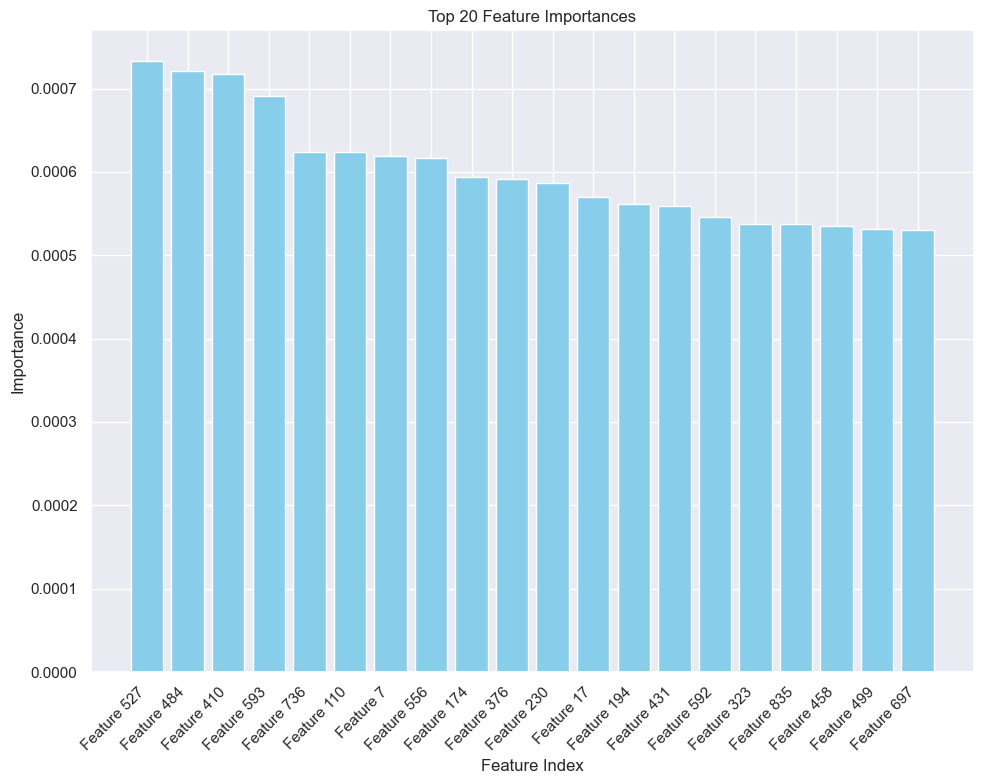

In [19]:
# Ensure model is in evaluation mode to disable dropout effects
only_dynamic_lstm_model.eval()

# Choose a sample or batch of data (here using one sample for simplicity)
input_tensor = dynamic_train_tensor[:1]  # Using the first sample from the training set
input_tensor.requires_grad = True  # Enable gradient computation for input

# Forward pass
output = only_dynamic_lstm_model(input_tensor)

# Since we are dealing with a binary classification, we focus on the gradient of the positive class output
output = output[0, 0]  # Assuming output is [batch_size, num_classes]

# Backward pass to compute gradients
output.backward()  # This populates the gradients in the input_tensor.grad attribute

# Retrieve the gradients
input_gradients = input_tensor.grad.data

# Aggregate gradients over the sequence and feature dimensions to get importance per feature across the sequence
feature_importances = torch.mean(torch.abs(input_gradients), dim=[0, 1])

# Sort the feature importances and return the indices that would sort the array
sorted_indices = torch.argsort(feature_importances, descending=True)

# Select the top 20 most important features
top20_indices = sorted_indices[:20]
top20_importances = feature_importances[top20_indices]

# Get feature names or indices for plotting (here using indices directly if names are not available)
feature_labels = [f'Feature {i+1}' for i in top20_indices]

# Plotting
plt.figure(figsize=(10, 8))
plt.bar(feature_labels, top20_importances.numpy(), color='skyblue')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 20 Feature Importances')
plt.xticks(rotation=45, ha='right')  # Rotate feature labels for better visibility
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

In [20]:
# Load feature names
feature_name_file = os.path.join(tensor_save_path, 'feature_names_dynamic_features.pkl')
with open(feature_name_file, 'rb') as file:
    feature_names = pickle.load(file)

# Assume 'importances' is a numpy array of feature importances obtained from your model
importance_dict = dict(zip(feature_names, feature_importances))

# Sort features by their importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print or plot the top N features
print("Top 20 features by importance:")
for feature, importance in sorted_importances[:20]:
    print(f"{feature}: {importance}")

# Convert the list of tuples into a DataFrame
importances_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])

# Specify the directory to save the file
save_directory = f'./saved_models/LSTM/lstm_model_only_dynamic_features_{percentage}/'
save_path = save_directory + 'feature_importances.csv'

# Check if directory exists, if not, create it
import os
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Save the DataFrame to a CSV file
importances_df.to_csv(save_path, index=False)

print(f'Feature importances saved successfully to {save_path}')

# Plot the top 20 feature importances
top20_importances_df = importances_df.head(20)
plt.figure(figsize=(12, 8))
plt.bar(top20_importances_df['Feature'], top20_importances_df['Importance'], color='skyblue')
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.title(f'LSTM with Only Dynamic Features - Top 20 Feature Importances ({percentage} Subset)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate feature labels for better visibility
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels

# Save the plot to the same directory
plot_save_path = save_directory + 'top20_feature_importances.png'
plt.savefig(plot_save_path)
plt.close()

print(f'Feature importance plot saved successfully to {plot_save_path}')

Top 20 features by importance:
CHART_225628: 0.0007332155364565551
CHART_227429: 0.0007213365752249956
CHART_225668: 0.0007178359664976597
CHART_220624: 0.000691523018758744
CHART_228381: 0.0006237098714336753
MEDS_229632: 0.0006236115004867315
MEDS_225152: 0.0006185900419950485
CHART_225684: 0.00061649369308725
PROC_225315: 0.0005937677342444658
OUT_226605: 0.0005911890766583383
PROC_225439: 0.0005866384599357843
MEDS_221749: 0.0005694084684364498
PROC_226124: 0.000561534718144685
CHART_224162: 0.0005587080377154052
CHART_220603: 0.0005457805818878114
OUT_226599: 0.0005379684153012931
stay_id: 0.000537255487870425
CHART_220228: 0.0005355262546800077
CHART_220274: 0.0005318077164702117
CHART_227460: 0.0005307224928401411
Feature importances saved successfully to ./saved_models/LSTM/lstm_model_only_dynamic_features_1%/feature_importances.csv
Feature importance plot saved successfully to ./saved_models/LSTM/lstm_model_only_dynamic_features_1%/top20_feature_importances.png


# Train LSTM Model Repeating Static Features

In [21]:
# Reset parameters
best_val_loss = float('inf')
epochs_no_improve = 0

In [22]:
# Model instantiation
num_time_steps = train_tensor_repeated_static_features.shape[1]
num_dynamic_features = train_tensor_repeated_static_features.shape[2]
num_static_features = train_tensor_repeated_static_features.shape[1]

lstm_model_repeating_features = LSTMModel(num_time_steps, num_dynamic_features)

C:\Users\soere\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [23]:
# Calculate class weights
class_counts = label_train_tensor.long().bincount()
total_counts = class_counts.sum()
class_weights = total_counts / class_counts  # This will give more weight to the minority class

# Apply weights to the loss function
weights = class_weights[label_train_tensor.long()]
criterion = nn.BCELoss()

In [24]:
# Loss function and optimizer
#criterion = nn.BCELoss()
optimizer = optim.Adam(lstm_model_repeating_features.parameters(), lr=0.001)

# Training loop
num_epochs = 100
best_val_loss = float('inf')

In [25]:
early_stopping_patience = 10

for epoch in range(num_epochs):
    lstm_model_repeating_features.train()
    total_loss = 0
    for dynamic_input, labels in repeated_static_features_train_loader:
        optimizer.zero_grad()
        outputs = lstm_model_repeating_features(dynamic_input).squeeze()
        outputs = outputs.view(-1)  # Flatten the output
        labels = labels.view(-1)  # Flatten the labels

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation loss computation
    val_loss = 0
    with torch.no_grad():
        for dynamic_input, labels in repeated_static_features_val_loader:
            outputs = lstm_model_repeating_features(dynamic_input).squeeze()
            outputs = outputs.view(-1)
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = total_loss / len(repeated_static_features_train_loader)
    avg_val_loss = val_loss / len(repeated_static_features_val_loader)

    # Print the average losses for the current epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Check if the current validation loss is the best we've seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(lstm_model_repeating_features.state_dict(), './saved_models/LSTM/state_dict/best_lstm_model_repeating_features.pth')  # Save under a correct name
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping initiated.")
            break

Epoch 1/100, Training Loss: 0.5227, Validation Loss: 0.3939
Epoch 2/100, Training Loss: 0.3063, Validation Loss: 0.3398
Epoch 3/100, Training Loss: 0.2367, Validation Loss: 0.2845
Epoch 4/100, Training Loss: 0.1890, Validation Loss: 0.2997
Epoch 5/100, Training Loss: 0.1447, Validation Loss: 0.2888
Epoch 6/100, Training Loss: 0.1025, Validation Loss: 0.2703
Epoch 7/100, Training Loss: 0.0753, Validation Loss: 0.2663
Epoch 8/100, Training Loss: 0.0466, Validation Loss: 0.2729
Epoch 9/100, Training Loss: 0.0280, Validation Loss: 0.2856
Epoch 10/100, Training Loss: 0.0228, Validation Loss: 0.3632
Epoch 11/100, Training Loss: 0.0161, Validation Loss: 0.3256
Epoch 12/100, Training Loss: 0.0118, Validation Loss: 0.3309
Epoch 13/100, Training Loss: 0.0104, Validation Loss: 0.3556
Epoch 14/100, Training Loss: 0.0084, Validation Loss: 0.3940
Epoch 15/100, Training Loss: 0.0066, Validation Loss: 0.3327
Epoch 16/100, Training Loss: 0.0056, Validation Loss: 0.3683
Epoch 17/100, Training Loss: 0.00

In [26]:
# Load the best LSTM model
lstm_model_repeating_features.load_state_dict(torch.load('./saved_models/LSTM/state_dict/best_lstm_model_repeating_features.pth'))

# Make predictions
lstm_model_repeating_features.eval()
with torch.no_grad():
    test_outputs = lstm_model_repeating_features(test_tensor_repeated_static_features).squeeze()
    test_loss = criterion(test_outputs, label_test_tensor)
    test_predictions = (test_outputs > 0.5).int()

print(f"Test Loss: {test_loss.item()}")
print(f"Test Accuracy: {(test_predictions == label_test_tensor.int()).float().mean().item()}")

Test Loss: 0.2601236402988434
Test Accuracy: 0.8873239159584045


In [27]:
# Evaluate LSTM model with only dynamic features
evaluate_lstm_model(lstm_model_repeating_features, test_tensor_repeated_static_features, label_test_tensor, f'./saved_models/LSTM/lstm_model_repeating_static_features_{percentage}', 'LSTM_Repeating_Static_Features')

Best Threshold: 0.08
LSTM_Repeating_Static_Features Model Performance on Test Set:
Accuracy: 0.77
Precision: 0.22
Recall: 0.67
F1 Score: 0.33
AUC-ROC: 0.83
AUPRC: 0.26
Performance metrics saved to: ./saved_models/LSTM/lstm_model_repeating_static_features_1%/LSTM_Repeating_Static_Features_metrics.txt


C:\Users\soere\AppData\Local\Temp\ipykernel_18184\2823572345.py:17: RuntimeWarning: invalid value encountered in divide
  f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)


In [28]:
# Save the entire model
torch.save(lstm_model_repeating_features, f'./saved_models/LSTM/lstm_model_repeating_static_features_{percentage}/lstm_model_repeating_static_features_{percentage}.pth')

Feature Importance Analysis

In [ ]:
# Ensure model is in evaluation mode to disable dropout effects
lstm_model_repeating_features.eval()

# Choose a batch of data
input_tensor = train_tensor_repeated_static_features[:batch_size]  # Adjust batch_size as needed
input_tensor.requires_grad = True  # Enable gradient computation for input

# Forward pass
outputs = lstm_model_repeating_features(input_tensor)

# Focus on the positive class output for binary classification
# Assuming output is [batch_size, num_classes], focus on one class if needed
outputs = outputs[:, 0]  # Assuming you are interested in the first class

# Backward pass to compute gradients for each sample in the batch
outputs.sum().backward()  # Sum needed to get a scalar for backward

# Retrieve the gradients
input_gradients = input_tensor.grad.data

# Aggregate gradients over the sequence and feature dimensions to get importance per feature across the sequence
# Average across the batch dimension (dim=0)
feature_importances = torch.mean(torch.abs(input_gradients), dim=0).mean(dim=0)

# Sort the feature importances and return the indices that would sort the array
sorted_indices = torch.argsort(feature_importances, descending=True)

# Select the top 20 most important features
top20_indices = sorted_indices[:20]
top20_importances = feature_importances[top20_indices]

# Get feature names or indices for plotting (here using indices directly if names are not available)
feature_labels = [f'Feature {i+1}' for i in top20_indices]

# Plotting
plt.figure(figsize=(10, 8))
plt.bar(feature_labels, top20_importances.numpy(), color='skyblue')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 20 Feature Importances')
plt.xticks(rotation=45, ha='right')  # Rotate feature labels for better visibility
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

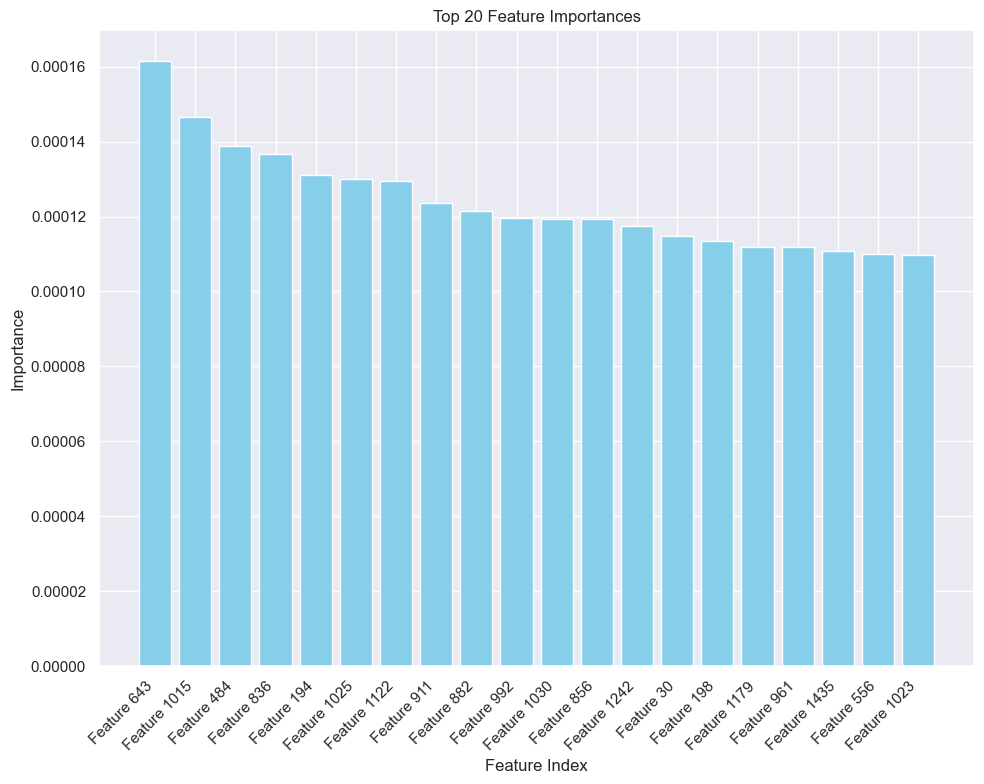

In [29]:
# Ensure model is in evaluation mode to disable dropout effects
lstm_model_repeating_features.eval()

# Choose a sample or batch of data (here using one sample for simplicity)
input_tensor = train_tensor_repeated_static_features[:1]  # Using the first sample from the training set
input_tensor.requires_grad = True  # Enable gradient computation for input

# Forward pass
output = lstm_model_repeating_features(input_tensor)

# Since we are dealing with a binary classification, we focus on the gradient of the positive class output
output = output[0, 0]  # Assuming output is [batch_size, num_classes]

# Backward pass to compute gradients
output.backward()  # This populates the gradients in the input_tensor.grad attribute

# Retrieve the gradients
input_gradients = input_tensor.grad.data

# Aggregate gradients over the sequence and feature dimensions to get importance per feature across the sequence
feature_importances = torch.mean(torch.abs(input_gradients), dim=[0, 1])

# Sort the feature importances and return the indices that would sort the array
sorted_indices = torch.argsort(feature_importances, descending=True)

# Select the top 20 most important features
top20_indices = sorted_indices[:20]
top20_importances = feature_importances[top20_indices]

# Get feature names or indices for plotting (here using indices directly if names are not available)
feature_labels = [f'Feature {i+1}' for i in top20_indices]

# Plotting
plt.figure(figsize=(10, 8))
plt.bar(feature_labels, top20_importances.numpy(), color='skyblue')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 20 Feature Importances')
plt.xticks(rotation=45, ha='right')  # Rotate feature labels for better visibility
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

In [30]:
# Load feature names
feature_name_file = os.path.join(tensor_save_path, 'feature_names_all_train_feaures.pkl')
with open(feature_name_file, 'rb') as file:
    feature_names = pickle.load(file)

# Assume 'importances' is a numpy array of feature importances obtained from your model
importance_dict = dict(zip(feature_names, feature_importances))

# Sort features by their importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print or plot the top N features
print("Top 20 features by importance:")
for feature, importance in sorted_importances[:20]:
    print(f"{feature}: {importance}")

# Convert the list of tuples into a DataFrame
importances_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])

# Specify the directory to save the file
save_directory = f'./saved_models/LSTM/lstm_model_repeating_static_features_{percentage}/'
save_path = save_directory + 'feature_importances.csv'

# Check if directory exists, if not, create it
import os
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Save the DataFrame to a CSV file
importances_df.to_csv(save_path, index=False)

print(f'Feature importances saved successfully to {save_path}')

# Plot the top 20 feature importances
top20_importances_df = importances_df.head(20)
plt.figure(figsize=(12, 8))
plt.bar(top20_importances_df['Feature'], top20_importances_df['Importance'], color='skyblue')
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.title(f'LSTM with Repeated Static Features - Top 20 Feature Importances ({percentage} Subset)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate feature labels for better visibility
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels

# Save the plot to the same directory
plot_save_path = save_directory + 'top20_feature_importances.png'
plt.savefig(plot_save_path)
plt.close()

print(f'Feature importance plot saved successfully to {plot_save_path}')

Top 20 features by importance:
CHART_227516: 0.00016159670485649258
N05: 0.00014667749928776175
CHART_227429: 0.000138834526296705
stay_id: 0.0001367846125504002
PROC_226124: 0.00013114722969476134
S06: 0.0001299932337133214
T50: 0.00012961508764419705
I50: 0.00012360616528894752
J96: 0.0001213624855154194
Z68: 0.00011953492503380403
I24: 0.00011940822150791064
ethnicity_UNKNOWN: 0.00011929863831028342
J84: 0.00011744128278223798
MEDS_225945: 0.0001148286901297979
PROC_228128: 0.00011334303417243063
R40: 0.00011184796312591061
K76: 0.00011178947170265019
Z84: 0.00011090468615293503
CHART_225684: 0.00011009340960299596
J69: 0.00010969049617415294
Feature importances saved successfully to ./saved_models/LSTM/lstm_model_repeating_static_features_1%/feature_importances.csv
Feature importance plot saved successfully to ./saved_models/LSTM/lstm_model_repeating_static_features_1%/top20_feature_importances.png
